### Process UNSEEN ###

But in notebook form.

In [1]:
%matplotlib inline
%reload_ext autoreload

# Local imports
import os
import sys
import time
import argparse

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import cartopy.io.shapereader as shpreader
import iris

# Specific imports
from tqdm import tqdm
from datetime import datetime, timedelta

# Load my specific functions
sys.path.append("/home/users/benhutch/unseen_functions")
import functions as funcs
import bias_adjust as ba

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# Hardcoded variables
model = "CESM1-1-CAM5-CMIP5" # Try the canadian model
experiment = "dcppA-hindcast"
freq = "Amon" # go back to using monthly data

# Set up the arguments
variable = "tas" # Obs Tas already regridded to HadGEM grid 
country = "United Kingdom"
season = "ONDJFM"
model_season = "ONDJFM"
first_year = 1960
last_year = 1962
model_fcst_year = 1
lead_year = "1-9" # only 1-9 for CanESM5
detrend = True # True for temperature, false for wind speeds
bias_correct = "None" # No bias correction for tas months
percentile = 10

# Save directory
save_dir = "/gws/nopw/j04/canari/users/benhutch/plots/unseen"

# list of valid bias corrections
valid_bias_corrections = [
    "None",
    "linear_scaling",
    "variance_scaling",
    "quantile_mapping",
    "quantile_delta_mapping",
    "scaled_distribution_mapping",
]

# Set up the output directory for the dfs
output_dir_dfs = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"

In [3]:
# if the bias correction is not in the valid bias corrections
if bias_correct not in valid_bias_corrections:
    raise ValueError(f"Bias correction {bias_correct} not recognised")

# set up the obs variable depending on the variable
if variable == "tas":
    obs_var = "t2m"
elif variable == "sfcWind":
    obs_var = "si10"
else:
    raise ValueError("Variable not recognised")

# Set up the months depending on the season
if season == "DJF":
    months = [12, 1, 2]
elif season == "D":
    months = [12]
elif season == "NDJ":
    months = [11, 12, 1]
elif season == "OND":
    months = [10, 11, 12]
elif season == "JFM":
    months = [1, 2, 3]
elif season == "MAM":
    months = [3, 4, 5]
elif season == "JJA":
    months = [6, 7, 8]
elif season == "SON":
    months = [9, 10, 11]
elif season == "ONDJFM":
    months = [10, 11, 12, 1, 2, 3]
elif season == "NDJFM":
    months = [11, 12, 1, 2, 3]
else:
    raise ValueError("Season not recognised")

# Depending on the model forecast year
# set the leads to extract from the model
if model == "HadGEM3-GC31-MM":
    if model_fcst_year == 0 and season == "NDJFM":
        lead_months = [1, 2, 3, 4, 5]
    elif model_fcst_year == 1 and season == "ONDJFM":
        lead_months = [12, 13, 14, 15, 16, 17]
    elif model_fcst_year == 1 and season in ["OND", "NDJ", "DJF", "JFM", "D"]:
        lead_months = [12, 13, 14, 15, 16, 17] # include all then subset later
    else:
        raise ValueError("Model forecast year and season not recognised")
elif model == "CanESM5":
    if model_fcst_year == 1 and season == "ONDJFM":
        lead_months = [10, 11, 12, 13, 14, 15]
    elif model_fcst_year == 1 and season in ["OND", "NDJ", "DJF", "JFM", "D"]:
        lead_months = [10, 11, 12, 13, 14, 15]
else:
    raise ValueError("Model not recognised")

In [4]:
# Set up the name for the obs df
obs_df_name = f"ERA5_obs_{variable}_{country}_{model_season}_{first_year}_{last_year}.csv"

# Set up the name for the model df
model_df_name = f"{model}_{variable}_{country}_{model_season}_{first_year}_{last_year}_{experiment}_{freq}.csv"

# form the full paths for the dfs
obs_df_path = os.path.join(output_dir_dfs, obs_df_name)
model_df_path = os.path.join(output_dir_dfs, model_df_name)

In [5]:
%%time

# if the obs df exists and the model df exists
if os.path.exists(obs_df_path) and os.path.exists(model_df_path):
    print("Loading the observed and model dfs")

    # load the dfs
    obs_df = pd.read_csv(obs_df_path)
    model_df = pd.read_csv(model_df_path)

    # print("Loaded the dfs")
    # print("----------------")
    # print("Script complete")
else:
    print("Creating the observed and model dfs")
    # Set up the path to the ERA5 data
    # if the variable is tas
    if variable == "tas":
        # already regridded!
        obs_path = (
            "/gws/nopw/j04/canari/users/benhutch/ERA5/t2m_ERA5_regrid_HadGEM.nc"
        )
    # if the variable is sfcWind
    elif variable == "sfcWind":
        # needs regridding
        obs_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/surface_wind_ERA5.nc"
    else:
        raise ValueError("Variable not recognised")

    # Load the model ensemble
    model_ds = funcs.load_model_data_xarray(
        model_variable=variable,
        model=model,
        experiment=experiment,
        start_year=first_year,
        end_year=last_year,
        first_fcst_year=int(first_year) + 1,
        last_fcst_year=int(first_year) + 2,
        months=months,
        frequency=freq,
        parallel=False,
    )

    # print that we have loaded the model data
    print("Loaded the model data")

    # # Get the size of the model data in bytes
    # size_in_bytes = model_ds[variable].size * model_ds[variable].dtype.itemsize

    # # Convert bytes to gigabytes
    # size_in_gb = size_in_bytes / (1024 ** 3)

    # # Print the size
    # print(f"Model data size: {size_in_gb} GB")

    # Modify member coordiante before conbersion to iris
    model_ds["member"] = model_ds["member"].str[1:-6].astype(int)

    # convert to an iris cube
    model_cube = model_ds[variable].squeeze().to_iris()

    # Load the observed data
    obs_ds = xr.open_mfdataset(
        obs_path,
        combine="by_coords",
        parallel=False,
        engine="netcdf4",
    )

    # Restrict the time to the region we are interested in
    obs_ds = obs_ds.sel(
        time=slice(
            f"{int(first_year)}-{months[0]}-01",
            f"{int(last_year) + 1}-{months[-1]}-31",
        )
    )

    # If expver is present in the observations
    if "expver" in obs_ds.coords:
        # Combine the first two expver variables
        obs_ds = obs_ds.sel(expver=1).combine_first(obs_ds.sel(expver=5))

    # # Get the size of the observed data in bytes
    # size_in_bytes = obs_ds[obs_var].size * obs_ds[obs_var].dtype.itemsize

    # # Convert bytes to gigabytes
    # size_in_gb = size_in_bytes / (1024 ** 3)

    # # Print the size
    # print(f"Observed data size: {size_in_gb} GB")

    # convert to an iris cube
    obs_cube = obs_ds[obs_var].squeeze().to_iris()

    # if the lats and lons are not the same
    if (
        not model_cube.coord("latitude").shape == obs_cube.coord("latitude").shape
        or not model_cube.coord("longitude").shape
        == obs_cube.coord("longitude").shape
    ):
        print("Regridding model data")
        # regrid the obs cube to the model cube
        obs_cube = obs_cube.regrid(model_cube, iris.analysis.Linear())

    # make sure the cubes are correct in -180 to 180 lons
    obs_cube = obs_cube.intersection(longitude=(-180, 180))
    model_cube = model_cube.intersection(longitude=(-180, 180))

    # create the mask
    MASK_MATRIX = funcs.create_masked_matrix(
        country=country,
        cube=model_cube,
    )

    # print the shape of the mask matrix
    print(f"Mask matrix shape: {MASK_MATRIX.shape}")

    # print the sum of the mask matrix
    print(f"Mask matrix sum: {np.sum(MASK_MATRIX)}")

    # Apply the mask to the observed data
    obs_values = obs_cube.data * MASK_MATRIX
    model_values = model_cube.data * MASK_MATRIX

    # Where there are zeros in the mask we want to set these to Nans
    obs_values_masked = np.where(MASK_MATRIX == 0, np.nan, obs_values)
    model_values_masked = np.where(MASK_MATRIX == 0, np.nan, model_values)

    # Take the Nanmean of the data
    obs_values = np.nanmean(obs_values_masked, axis=(1, 2))
    model_values = np.nanmean(model_values_masked, axis=(3, 4))

    # Set up the ref time for the observations
    ref_time_obs = datetime(1900, 1, 1)

    # Extract the obs time points
    obs_time_points = obs_cube.coord("time").points

    # convert to obs datetimes
    obs_datetimes = [
        ref_time_obs + timedelta(hours=int(tp)) for tp in obs_time_points
    ]

    # Set up a dataframe for the observations
    obs_df = pd.DataFrame(
        {
            "time": obs_datetimes,
            "obs": obs_values,
        }
    )

    # set up an empty df for the model data
    model_df = pd.DataFrame()

    # extract the init, member and lead time points
    init_years = model_cube.coord("init").points
    members = model_cube.coord("member").points
    lead_times = model_cube.coord("lead").points

    # loop through the inits, members and leadtimes
    for i, init_year in enumerate(init_years):
        for m, member in enumerate(members):
            for l, lead_time in enumerate(lead_times):
                # get the model data
                model_data = model_values[i, m, l]

                # set up the model df this
                model_df_this = pd.DataFrame(
                    {
                        "init_year": [init_year],
                        "member": [member],
                        "lead": [lead_time],
                        "data": [model_data],
                    },
                )

                # concat to the model df
                model_df = pd.concat([model_df, model_df_this])

    # print the head of the obs df
    print(obs_df.head())

    # print the head of the model df
    print(model_df.head())

    # save the dfs
    if not os.path.exists(output_dir_dfs):
        os.makedirs(output_dir_dfs)

    # save the obs df
    if not os.path.exists(obs_df_path):
        print("Saving the observed df")
        obs_df.to_csv(obs_df_path, index=False)

    # save the model df
    if not os.path.exists(model_df_path):
        print("Saving the model df")
        model_df.to_csv(model_df_path, index=False)

Loading the observed and model dfs
CPU times: user 8.27 ms, sys: 964 μs, total: 9.23 ms
Wall time: 166 ms


In [6]:
# constrain the obs df to only months 10, 11, 12, 1, 2, 3
# esnure that the time is a datetime
obs_df["time"] = pd.to_datetime(obs_df["time"])

# set the time as the index for the obs df
obs_df.set_index("time", inplace=True)

# # remove the name of the index
# obs_df.index.name = None

# print the head of the obs df
print(obs_df.head())

# constrain to the months
obs_df = obs_df[obs_df.index.month.isin(months)]

# NOTE: Not taking ONDJFM averages
# if months contains 12, 1 in sequence
# if 12 in months and 1 in months:
#     # shift back by months and take the annual mean
#     obs_df = obs_df.shift(-int(months[-1])).resample("A").mean()

# if there are any Nans in the obs df, drop them
obs_df.dropna(inplace=True)

# set up time as a column
obs_df.reset_index(inplace=True)

                 obs
time                
1960-10-01  4.131944
1960-11-01  4.934281
1960-12-01  4.428460
1961-01-01  4.940405
1961-02-01  5.247938


In [7]:
lead_year

'1-9'

In [8]:
# create a new model df for subsetting to first ONDJFM
model_df_ondjfm = pd.DataFrame()

# turn leads into a list of ints
if lead_year != "9999":
    if "-" in lead_year:
        leads = list(
            range(
                int(lead_year.split("-")[0]),
                int(lead_year.split("-")[1]) + 1,
            )
        )
    else:
        leads = [int(lead_year)]

    # print the leads to extract
    print(f"Leads to extract: {leads}")
elif lead_year == "9999":
    if model == "HadGEM3-GC31-MM":
        # Set up the leads to extract list range 1-10
        leads = list(range(1, 11))
    elif model == "CanESM5":
        # Set up the leads to extract list range 1-6
        leads = list(range(1, 10))
    else:
        raise ValueError("Model not recognised")
else:
    raise ValueError("Lead year not recognised")

Leads to extract: [1, 2, 3, 4, 5, 6, 7, 8, 9]


In [9]:
lead_months

[10, 11, 12, 13, 14, 15]

In [10]:
# loop over the unique init years and members in model_df
for init_year in model_df["init_year"].unique():
    for member in model_df["member"].unique():
        for l in leads:
            # extract the model data
            model_data = model_df[
                (model_df["init_year"] == init_year)
                & (model_df["member"] == member)
            ]

            # create the list of lead months to extract
            lead_months_year_base = [l * lead_months[0] for lm in lead_months]

            # # print the lead months year base
            # print("lead months year base:", lead_months_year_base)

            # create the list of lead months to extract
            for i in range(len(lead_months_year_base)):
                lead_months_year_base[i] = lead_months_year_base[i] + i

            # # print the lead months year base
            # print("lead months year base:", lead_months_year_base)

            # # subset to lead values [12, 13, 14, 15, 16, 17] and take the mean
            # # first complete ONDJFM season
            # # FIXME: Hardcoded for now
            # model_data = model_data[model_data["lead"].isin(lead_months_year_base)]

            # mean_data = model_data["data"].mean()
                
            # # print lead months year base
            # print("lead months year base:", lead_months_year_base)

            # loop over the lead months
            for lm in lead_months_year_base:
                # subset to the lead month
                mean_data = model_data[model_data["lead"] == lm].mean()["data"]

                # create a dataframe this
                model_data_this = pd.DataFrame(
                    {
                        "init_year": [init_year],
                        "member": [member],
                        "lead": [lm],
                        "data": [mean_data],
                    }
                )

                model_df_ondjfm = pd.concat([model_df_ondjfm, model_data_this])

In [12]:
model_df_ondjfm.head()

,init_year,member,lead,data
0,1960,10,10,6.173814
0,1960,10,11,7.584284
0,1960,10,12,9.387999
0,1960,10,13,9.358269
0,1960,10,14,9.115392


In [9]:
# # FIXME: Hardcoded for now - SUBSETTING TO DECEMBER ONLY
# # Subset to december
# lead_years = np.arange(1, 11)

# # set up the months
# months = [12]

# model_df_subset = pd.DataFrame()

# for ly in lead_years:
#     # Subset the df to the month and lead year
#     model_df_subset_this = model_df_ondjfm[
#         (model_df_ondjfm["lead"] == (ly * 12) + 2) # Fixed at 2 in this case
#     ]

#     # concat to the model df subset
#     model_df_subset = pd.concat([model_df_subset, model_df_subset_this])

In [10]:
# if the detrend is True
if detrend and bias_correct == "None":
    print("Detrending the data, no bias correction")

    # apply the function to detrend the data
    obs_df, model_df_ondjfm = funcs.apply_detrend(
        obs_df=obs_df,
        model_df=model_df_ondjfm,
        obs_val_name="obs",
        model_val_name="data",
        obs_time_name="time",
        model_time_name="init_year",
        model_member_name="member",
        model_lead_name="lead",
    )

    # Set up the name for the obs val name
    obs_val_name = "obs_dt"
    model_val_name = "data_dt"
elif bias_correct != "None" and not detrend:
    print("Bias correcting the data, no detrending")

    # if the bias correction is linear_scaling
    if bias_correct == "linear_scaling":
        # apply the function to bias correct the data
        model_df_ondjfm = funcs.bc_linear_scaling(
            obs_df=obs_df,
            model_df=model_df_ondjfm,
            obs_val_name="obs",
            model_val_name="data",
        )
    elif bias_correct == "variance_scaling":
        # apply the function to bias correct the data
        model_df_ondjfm = funcs.bc_variance_scaling(
            obs_df=obs_df,
            model_df=model_df_ondjfm,
            obs_val_name="obs",
            model_val_name="data",
        )
    elif bias_correct == "quantile_mapping":
        # Use James functions to correct the model data
        qm_adjustment = ba.QMBiasAdjust(
            obs_data = obs_df["obs"],
            mod_data = model_df_ondjfm["data"],
        )

        # assign the corrected data to the model df
        model_df_ondjfm["data_bc"] = qm_adjustment.correct()
    elif bias_correct == "quantile_delta_mapping":
        # Use James functions to correct the model data
        qdm_adjustment = ba.QDMBiasAdjust(
            obs_data = obs_df["obs"],
            mod_data = model_df_ondjfm["data"],
        )

        # assign the corrected data to the model df
        model_df_ondjfm["data_bc_qdm"] = qdm_adjustment.correct()

        # compare to the quantile mapping adjustment
        qm_adjustment = ba.QMBiasAdjust(
            obs_data = obs_df["obs"],
            mod_data = model_df_ondjfm["data"],
        )

        # assign the corrected data to the model df
        model_df_ondjfm["data_bc_qm"] = qm_adjustment.correct()

        # take the difference between the two columns
        model_df_ondjfm["data_bc_diff"] = model_df_ondjfm["data_bc_qm"] - model_df_ondjfm["data_bc_qdm"]

        # print the head of the model df
        print(model_df_ondjfm.head())

        # print the tail of the model df
        print(model_df_ondjfm.tail())
    elif bias_correct == "scaled_distribution_mapping":
        print("Applying scaled distribution mapping")

        sdm_adjustment = ba.SDMBiasAdjust(
            obs_data = obs_df["obs"],
            mod_data = model_df_ondjfm["data"],
        )

        # assign the corrected data to the model df
        model_df_ondjfm["data_bc"] = sdm_adjustment.correct()
    else:
        print(f"Bias correction method {bias_correct} not recognised")

    # Set up the name for the obs val name
    obs_val_name = "obs"
    model_val_name = "data_bc"

    # print the mean bias
    print(
        "Mean bias:",
        np.mean(model_df_ondjfm[model_val_name]) - np.mean(obs_df[obs_val_name]),
    )

    # print the spread bias
    print(
        "Spread bias:",
        np.std(model_df_ondjfm[model_val_name]) - np.std(obs_df[obs_val_name]),
    )

elif bias_correct != "None" and detrend:
    print("Bias correcting the data and detrending")

    # apply the function to detrend the data
    obs_df, model_df_ondjfm = funcs.apply_detrend(
        obs_df=obs_df,
        model_df=model_df_ondjfm,
        obs_val_name="obs",
        model_val_name="data",
        obs_time_name="time",
        model_time_name="init_year",
        model_member_name="member",
        model_lead_name="lead",
    )

    # # print the mean of the model data
    # print("Model data mean before bias correction:", np.mean(model_df_ondjfm["data_dt"]))

    # # print the spread of the model data
    # print("Model data spread before bias correction:", np.std(model_df_ondjfm["data_dt"]))

    if bias_correct == "linear_scaling":
        # apply the function to bias correct the data
        model_df_ondjfm = funcs.bc_linear_scaling(
            obs_df=obs_df,
            model_df=model_df_ondjfm,
            obs_val_name="obs_dt",
            model_val_name="data_dt",
        )
    elif bias_correct == "variance_scaling":
        # apply the function to bias correct the data
        model_df_ondjfm = funcs.bc_variance_scaling(
            obs_df=obs_df,
            model_df=model_df_ondjfm,
            obs_val_name="obs_dt",
            model_val_name="data_dt",
        )
    elif bias_correct == "quantile_mapping":
        # use James' functions to correct the model data
        qm_adjustment = ba.QMBiasAdjust(
            obs_data = obs_df["obs"],
            mod_data = model_df_ondjfm["data_dt"],
        )

        # assign the corrected data to the model df
        model_df_ondjfm["data_dt_bc"] = qm_adjustment.correct()
    elif bias_correct == "quantile_delta_mapping":
        # Use James functions to correct the model data
        qdm_adjustment = ba.QDMBiasAdjust(
            obs_data = obs_df["obs"],
            mod_data = model_df_ondjfm["data_dt"],
        )

        # assign the corrected data to the model df
        model_df_ondjfm["data_dt_bc"] = qdm_adjustment.correct()
    elif bias_correct == "scaled_distribution_mapping":
        print("Applying scaled distribution mapping")

        sdm_adjustment = ba.SDMBiasAdjust(
            obs_data = obs_df["obs"],
            mod_data = model_df_ondjfm["data_dt"],
        )

        # assign the corrected data to the model df
        model_df_ondjfm["data_dt_bc"] = sdm_adjustment.correct()
    else:
        print(f"Bias correction method {bias_correct} not recognised")
        sys.exit()

    # # print the mean of the model data
    # print("Model data mean after bias correction:", np.mean(model_df_ondjfm["data_dt_bc"]))

    # # print the spread of the model data
    # print("Model data spread after bias correction:", np.std(model_df_ondjfm["data_dt_bc"]))

    # # print the observed mean
    # print("Observed data mean before bias correction:", np.mean(obs_df["obs_dt"]))

    # # print the spread of the observed data
    # print("Observed data spread before bias correction:", np.std(obs_df["obs_dt"]))

    # sys.exit()

    # Set up the name for the obs val name
    obs_val_name = "obs_dt"
    model_val_name = "data_dt_bc"

else:
    obs_val_name = "obs"
    model_val_name = "data"

Detrending the data, no bias correction
The mean slope is 0.03007167605425015
The 2.5th percentile of the slopes is 0.004921807033942651
The 97.5th percentile of the slopes is 0.05187120580376486
The slope of the observations is 0.02825383544191476
The trend line obs is [277.31452504 277.31452504 277.31452504 277.31452504 277.31452504
 277.31452504 277.31452504 277.31452504 277.31452504 277.31452504
 277.31452504 277.31452504 277.31452504 277.31452504 277.31452504
 277.31452504 277.31452504 277.31452504 277.31452504 277.31452504
 277.31452504 277.31452504 277.31452504 277.31452504 277.31452504
 277.31452504 277.31452504 277.31452504 277.31452504 277.31452504
 277.31452504 277.31452504 277.31452504 277.31452504 277.31452504
 277.31452504 277.31452504 277.31452504 277.31452504 277.31452504
 277.31452504 277.31452504 277.31452504 277.31452504 277.31452504
 277.31452504 277.31452504 277.31452504 277.31452504 277.31452504
 277.31452504 277.31452504 277.31452504 277.31452504 277.31452504
 27

In [11]:
# print the obs val name being used
print("----------------")
print(f"Obs val name: {obs_val_name}")
print(f"Model val name: {model_val_name}")
print("----------------")

----------------
Obs val name: obs_dt
Model val name: data_dt
----------------


In [12]:
model_df_ondjfm.head()

,init_year,member,lead,data,data_dt
0,1960,10,12,283.084343,284.828501
0,1960,10,13,278.981183,280.725340
0,1960,10,14,275.849635,277.593792
0,1960,10,15,276.140779,277.884937
0,1960,10,16,276.147612,277.891769


The ks stat is 0.05135593220338984
The ks p is 0.30399829224160546
at alpha = 0.05, the critical value is 0.07264370134177339
at alpha = 0.01, the critical value is 0.08706561263756663
The null hypothesis is not rejected
The null hypothesis is not rejected


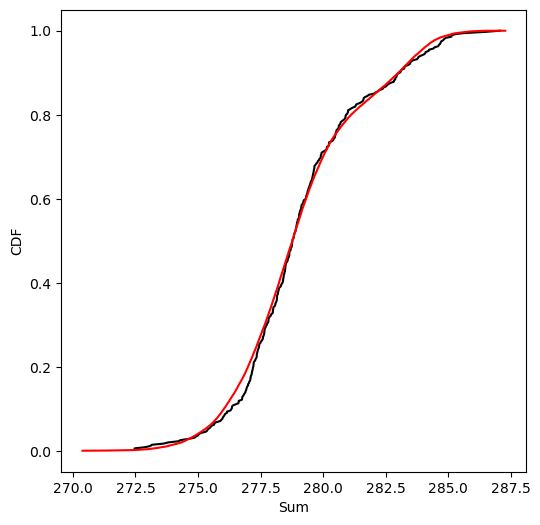

In [13]:
# plot the cdfs
funcs.plot_cdfs(
    obs_df=obs_df,
    model_df=model_df_ondjfm,
    obs_val_name=obs_val_name,
    model_val_name=model_val_name,
    save_prefix=f"cdfs_{variable}_{country}_{season}_{first_year}_{last_year}_{model}_{experiment}_{freq}_obs-{obs_val_name}_model-{model_val_name}_bc-{bias_correct}",
    save_dir=save_dir,
)

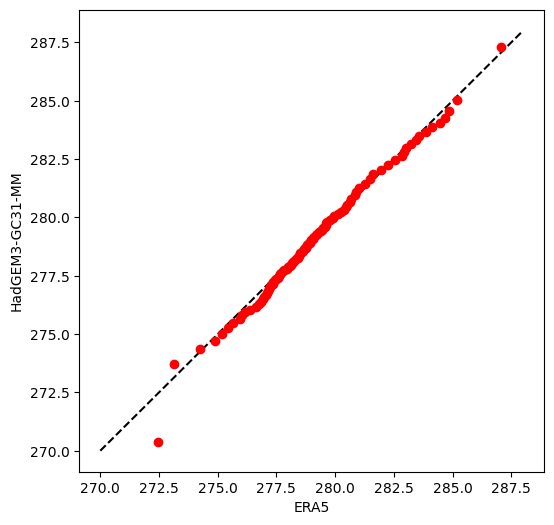

In [14]:
# do the Q-Q plot
funcs.plot_qq(
    obs_df=obs_df,
    model_df=model_df_ondjfm,
    obs_val_name=obs_val_name,
    model_val_name=model_val_name,
    save_prefix=f"qq_{variable}_{country}_{season}_{first_year}_{last_year}_{model}_{experiment}_{freq}_obs-{obs_val_name}_model-{model_val_name}_bc-{bias_correct}",
    save_dir=save_dir,
)

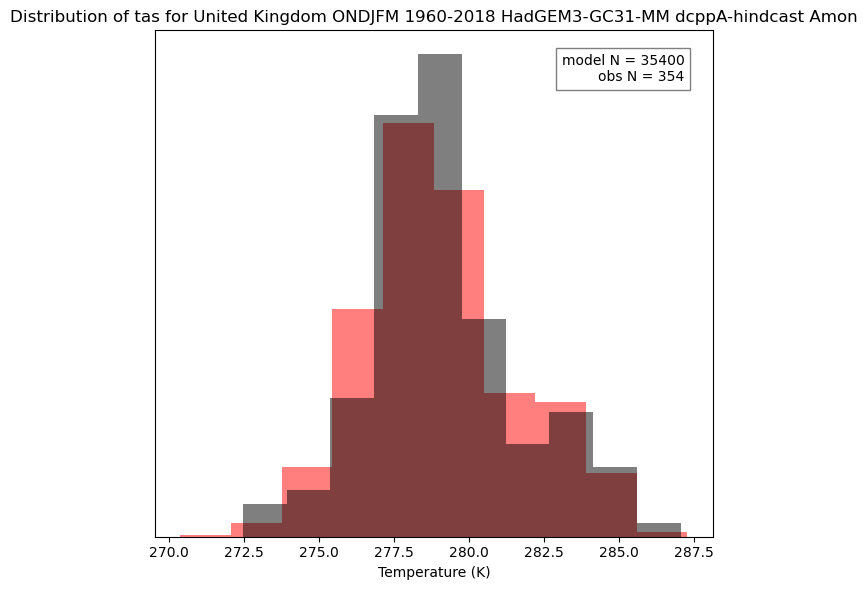

In [15]:
funcs.plot_distribution(
    obs_df=obs_df,
    model_df=model_df_ondjfm,
    xlabel="Temperature (K)",
    nbins=30,
    title=f"Distribution of {variable} for {country} {season} {first_year}-{last_year} {model} {experiment} {freq}",
    obs_val_name=obs_val_name,
    model_val_name=model_val_name,
    fname_prefix=f"distribution_{variable}_{country}_{season}_{first_year}_{last_year}_{model}_{experiment}_{freq}_obs-{obs_val_name}_model-{model_val_name}_bc-{bias_correct}",
    save_dir=save_dir,
)

The mean bias is -0.085266503632045
The spread bias is -0.011278124046672833
The number of unique model times is 59
The number of unique obs times is 354


Calculating bootstrap statistics: 100%|██████████| 1000/1000 [00:24<00:00, 40.16it/s]


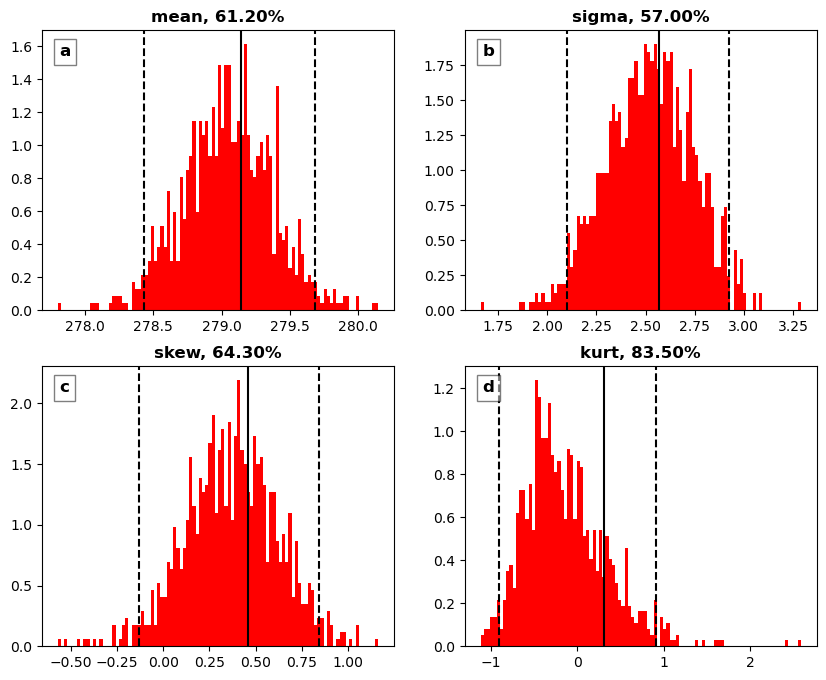

In [16]:
# plot the fidelity
funcs.plot_fidelity(
    obs_df=obs_df,
    model_df=model_df_ondjfm,
    obs_val_name=obs_val_name,
    model_val_name=model_val_name,
    obs_time_name="time",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name="lead",
    nboot=1000,
    figsize=(10, 8),
    save_dir=save_dir,
    fname_root=f"fidelity_{variable}_{country}_{season}_{first_year}_{last_year}_{model}_{experiment}_{freq}_obs-{obs_val_name}_model-{model_val_name}_bc-{bias_correct}",
)

In [17]:
obs_df.head()

,time,obs,obs_dt
0,1960-10-01,282.668868,284.413025
1,1960-11-01,279.559365,281.303522
2,1960-12-01,276.477476,278.221633
3,1961-01-01,275.904981,277.649139
4,1961-02-01,279.151625,280.895782


Text(0.5, 1.0, 'Boxplots of tas for United Kingdom ONDJFM 1960-2018 HadGEM3-GC31-MM dcppA-hindcast Amon')

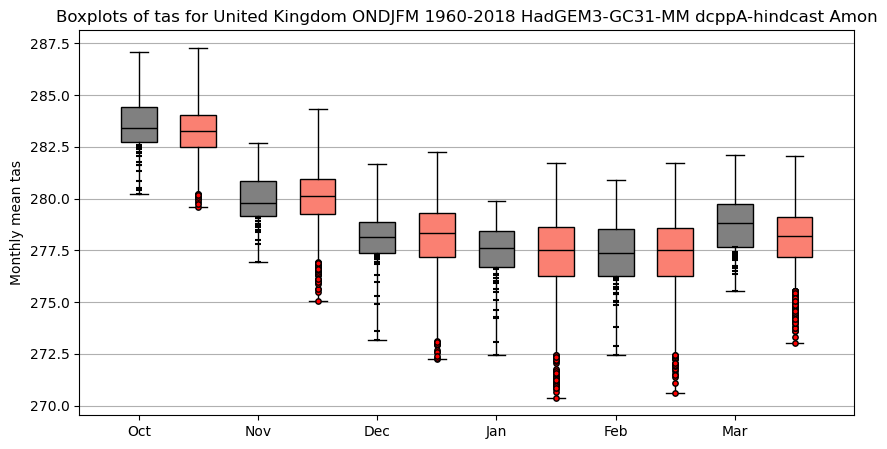

In [18]:
# plot the boxplots for the different months
# set up the figure size
plt.figure(figsize=(10, 5))

# Set up the month names for the x-axis
month_names = ["Oct", "Nov", "Dec", "Jan", "Feb", "Mar"]

# Set up the ylabel
plt.ylabel(f"Monthly mean {variable}")

# Set up the lead_years
lead_years = np.arange(1, 11)

# assert that months is 10, 11, 12, 1, 2, 3
assert months == [10, 11, 12, 1, 2, 3], "Months not recognised"

# # if variable is tas, convert to C
# if variable == "tas":
#     obs_df[obs_val_name] = obs_df[obs_val_name] - 273.15
#     model_df_ondjfm[model_val_name] = model_df_ondjfm[model_val_name] - 273.15

# Loop over the months
for i, month in enumerate(months):
    # subset to the month
    obs_df_month = obs_df[obs_df["time"].dt.month == month]

    leads_this_month = []

    # find the leads to extract
    for ly in lead_years:
        leads_this_month.append((ly * 12) + i)

    # subset to the leads
    model_df_month = model_df_ondjfm[model_df_ondjfm["lead"].isin(leads_this_month)]

    # Calculate the upper quartile (75th percentile)
    obs_lower_quartile = np.percentile(obs_df_month[obs_val_name], 25)
    model_lower_quartile = np.percentile(model_df_month[model_val_name], 25)

    # calculate the obs min value for the month
    obs_min = np.min(obs_df_month[obs_val_name])

    # Plot the observed data in black
    obs_box = plt.boxplot(
        obs_df_month[obs_val_name],
        positions=[i + 1],
        widths=0.3,
        showfliers=False,
        boxprops=dict(color='black'),
        capprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        flierprops=dict(markerfacecolor='black', marker='o'),
        medianprops=dict(color='black'),
        whis=[0, 100], # the 0th and 100th percentiles (i.e. min and max)
        patch_artist=True
    )

    # Set the face color for the observed data box
    for box in obs_box['boxes']:
        box.set(facecolor='grey')

    # Plot the model data in red
    model_box = plt.boxplot(
        model_df_month[model_val_name],
        positions=[i + 1.5],
        widths=0.3,
        showfliers=False,
        boxprops=dict(color='black'),
        capprops=dict(color='black'),
        whiskerprops=dict(color='black'),
        flierprops=dict(markerfacecolor='black', marker='o'),
        medianprops=dict(color='black'),
        whis=[0, 100], # the 0th and 100th percentiles (i.e. min and max)
        patch_artist=True,
    )

    # Set the face color for the model data box
    for box in model_box['boxes']:
        box.set(facecolor='salmon')    

    # add scatter points for obs values beneath the lower quartile
    obs_below_lower_quartile = obs_df_month[obs_val_name][obs_df_month[obs_val_name] < obs_lower_quartile]
    plt.scatter(
        [i + 1] * len(obs_below_lower_quartile),
        obs_below_lower_quartile,
        color="black",
        marker="_",
        s=15,
        zorder=10,
    )

    # # add scatter points for model values beneath the lower quartile
    # model_below_lower_quartile = model_df_month[model_val_name][model_df_month[model_val_name] < model_lower_quartile]
    # plt.scatter(
    #     [i + 1.5] * len(model_below_lower_quartile),
    #     model_below_lower_quartile,
    #     color="red",
    #     marker="_",
    #     s=20,
    # )

    # add red dots for the points which are lower than the obs min
    model_below_obs_min = model_df_month[model_val_name][model_df_month[model_val_name] < obs_min]

    # plot the model data
    plt.scatter(
        [i + 1.5] * len(model_below_obs_min),
        model_below_obs_min,
        color="red",
        edgecolor="black",
        marker="o",
        s=15,
        zorder=10,
    )

# include gridlines
plt.grid(axis="y")

# set the xticks
plt.xticks(ticks=np.arange(1, 7), labels=month_names)

# set the title
plt.title(f"Boxplots of {variable} for {country} {season} {first_year}-{last_year} {model} {experiment} {freq}")

-0.9110714220237693
3.3989715542884427
(35400, 5)
         sorted  rank_sp  exceedance    period  probability
35399  3.398972  35400.0    0.999972  1.000028    99.997175
35398  3.390244  35399.0    0.999944  1.000056    99.994350
35397  3.339065  35398.0    0.999915  1.000085    99.991526
35396  3.331271  35397.0    0.999887  1.000113    99.988701
35395  3.293297  35396.0    0.999859  1.000141    99.985876
(35400, 6)
   init_year  member  lead        data     data_dt  data_dt_perc_change
0       1960      10    12  283.084343  284.828501             1.642948
0       1960      10    24  283.553097  285.297254             1.810226
0       1960      10    36  279.474315  281.218472             0.354685
0       1960      10    48  283.225406  284.969564             1.693287
0       1960      10    60  282.660350  284.404507             1.491643


100%|██████████| 1000/1000 [00:04<00:00, 205.41it/s]


(1000, 35400)


Text(0.5, 0, '% change relative to lowest observed value')

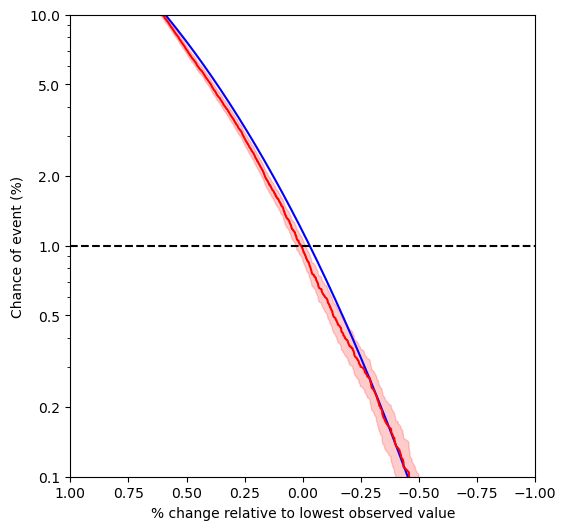

In [25]:
import matplotlib
import warnings
from scipy.stats import genextreme as gev

# silence the warnings
warnings.filterwarnings("ignore")

# Return periods relative to individual events
fig, ax = plt.subplots(figsize=(6, 6))

# Set up the probabilities
probs = 1 / np.arange(1.1, 1000, 0.1) * 100

years = np.arange(1.1, 1000, 0.1)

# assuming ONDJFM
# set up the lead years
lead_years = np.arange(1, 11)

# set up the months
months = [10, 11, 12, 1, 2, 3]

# Set up the number of samples
n_samples = 1000

# wiunter values
winter_values = []
winter_probs = []

# create a new dataframe
model_df_perc_change = pd.DataFrame()

# loop over the months
for m, month in enumerate(months):

    # Select this month from the observations
    obs_month = obs_df[obs_df["time"].dt.month == month]

    # Find the minimum observed value for this month
    obs_month_min = np.min(obs_month[obs_val_name])

    leads_this_month = []

    # llop over the lead years
    for ly in lead_years:
        leads_this_month.append((ly * 12) + m)

    # subset to the leads
    model_month = model_df_ondjfm[model_df_ondjfm["lead"].isin(leads_this_month)]

    # Quantify a new column as f"{model_val_name}_perc_change"
    model_month[f"{model_val_name}_perc_change"] = (model_month[model_val_name] - obs_month_min) / obs_month_min * 100

    # concat to the model df perc change
    model_df_perc_change = pd.concat([model_df_perc_change, model_month])

# # print the head of the model df perc change
# print(model_df_perc_change.head())

# # print the tail of the model df perc change
# print(model_df_perc_change.tail())

# print the min and the max of the model df perc change model val name_perc_change columns
print(model_df_perc_change[f"{model_val_name}_perc_change"].min())
print(model_df_perc_change[f"{model_val_name}_perc_change"].max())

# quantify the return levels
model_df_rl = funcs.empirical_return_level(
    model_df_perc_change[f"{model_val_name}_perc_change"].values
)

# print the shape of model_df_rl
print(model_df_rl.shape)

# print the head of model_df_rl
print(model_df_rl.head())

# print the shape of model_df_perc_change
print(model_df_perc_change.shape)

# print the head of model_df_perc_change
print(model_df_perc_change.head())

# # create an empty array to store the return levels
model_vals = np.zeros([n_samples, len(model_df_perc_change)])

# set up the model params
params_model = []

# fit to the unaltered values
params_model.append(
    gev.fit(
        model_df_perc_change[f"{model_val_name}_perc_change"],
    )
)

# loop over the number of samples
for i in tqdm(range(n_samples)):
    # sample the model data
    model_vals_this = np.random.choice(
        model_df_perc_change[f"{model_val_name}_perc_change"],
        size=len(model_df_rl["sorted"]),
        replace=True,
    )

    # # append the fitted params to the params model
    # params_model.append(
    #     gev.fit(
    #         model_vals_this,
    #     )
    # )


    # calculate the return levels
    model_df_rl_sample = funcs.empirical_return_level(
        model_vals_this
    )

    # # plot the return levels
    # _ = plt.plot(
    #     model_df_rl_sample["sorted"],
    #     model_df_rl_sample["probability"],
    #     color="grey",
    #     alpha=0.5,
    # )


    # store the model vals
    model_vals[i, :] = model_df_rl_sample["sorted"]

# Initialize the list for the return levels
levels_model = []

# # given the params, fit the model
# for i in range(n_samples):
#     levels_model.append(
#         gev.ppf(
#             1 / years, 
#             *params_model[i],
#         )
#     )

levels_model = gev.ppf(
    1 / years,
    *params_model[0],
)

# turn this into an array
levels_model = np.array(levels_model)

# plot the mean return levels
_ = plt.plot(
    levels_model,
    probs,
    "b-",
)

# plot the return levels
_ = plt.plot(
    model_df_rl["sorted"],
    model_df_rl["probability"],
    color="red",
)

# print the shape of model_vals
print(model_vals.shape)

# calculate the percentiles
model_vals_025 = np.percentile(model_vals, 2.5, axis=0)
model_vals_975 = np.percentile(model_vals, 97.5, axis=0)


# # plot the model vals 023
# _ = plt.plot(
#     model_vals_025,
#     model_df_rl["probability"],
#     color="blue",
# )

# fill between the percentiles
plt.fill_betweenx(
    model_df_rl["probability"],
    model_vals_025,
    model_vals_975,
    color="red",
    alpha=0.2,
)

# calculate and plot the mean
model_vals_mean = np.mean(model_vals, axis=0)

# plot the model data mean
# _ = plt.plot(
#     model_df_rl["sorted"],
#     model_vals_mean,
#     color="blue",
# )

# # Plot the model data
# _ = plt.fill_between(
#     model_df_rl["probability"],
#     model_vals_025,
#     model_vals_975,
#     color="red",
#     alpha=0.2,
# )

# # # aesthetics
ax.set_ylim(0, 20)  # Adjust as needed

# horizontal line at 1
plt.axhline(1, color="black", linestyle="--")

# set the xpoints
x_points = np.array([20, 10, 5, 2, 1, 0.5, 0.2, 0.1])

# set the xlim
ax.set_xlim(1, -1)

ax.set_yscale("log")
# set the yticks
ax.set_yticks(x_points)

# set ylim
ax.set_ylim(0.1, 10)

ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel("Chance of event (%)")
# ax.set_xlabel(f"Lower than {obs_time_lowest} ({units})")

# Set the xlabel
ax.set_xlabel(f"% change relative to lowest observed value")

In [11]:
# test the function for quantifying autocorrelation
funcs.calc_autocorr_obs(
    obs_df=obs_df,
    obs_val_name=obs_val_name,
    months=months,
)

          10        11        12        1         2         3 
10  1.000000  0.025193  0.028966  0.059704  0.114830 -0.164148
11  0.025193  1.000000  0.208716 -0.102263 -0.213974  0.017586
12  0.028966  0.208716  1.000000  0.343496 -0.040848  0.144089
1   0.059704 -0.102263  0.343496  1.000000  0.177099  0.143182
2   0.114830 -0.213974 -0.040848  0.177099  1.000000  0.274659
3  -0.164148  0.017586  0.144089  0.143182  0.274659  1.000000


In [12]:
months

[10, 11, 12, 1, 2, 3]

In [13]:
# set up an empty list of monthly subsets
monthly_subsets = []

# Set up the lead_years
lead_years = np.arange(1, 11)

for i, m in enumerate(months):
    
    # Set up an empty list for the monthly subset
    monthly_subset = []

    # loop over the lead years
    for ly in lead_years:
        # print(f"Extracting {(ly * 12) + i} from the model df")

        # extract the data
        model_vals = model_df_ondjfm[
            (model_df_ondjfm["lead"] == (ly * 12) + i)
        ][model_val_name].values

        # extend the monthly subset to include the model vals
        monthly_subset.extend(model_vals)

    # append the monthly subset to the monthly subsets
    monthly_subsets.append(monthly_subset)

In [14]:
# set up a dataframe with the monthly subsets
monthly_df = pd.DataFrame(monthly_subsets).T

# name the columns
monthly_df.columns = months

In [15]:
# compute the correlations
corrs = monthly_df.corr()

In [16]:
# print the correlations
print(corrs)

# save this output as a csv
save_dir = "/home/users/benhutch/unseen_multi_year/dfs"

# set up the fname
fname = f"{model}_{variable}_{country}_{season}_{first_year}_{last_year}_{experiment}_{freq}_corrs.csv"

# if the path does not already exist
if not os.path.exists(os.path.join(save_dir, fname)):
    # save the correlations
    corrs.to_csv(os.path.join(save_dir, fname))

          10        11        12        1         2         3 
10  1.000000  0.003432 -0.024532  0.004166 -0.004965 -0.032655
11  0.003432  1.000000  0.109716  0.019204  0.000854  0.008080
12 -0.024532  0.109716  1.000000  0.175492  0.063895  0.033720
1   0.004166  0.019204  0.175492  1.000000  0.214029  0.114146
2  -0.004965  0.000854  0.063895  0.214029  1.000000  0.210538
3  -0.032655  0.008080  0.033720  0.114146  0.210538  1.000000


In [17]:
# Same for the observations
funcs.calc_autocorr_obs(
    obs_df=obs_df,
    obs_val_name=obs_val_name,
    months=months,
)

          10        11        12        1         2         3 
10  1.000000  0.025193  0.028966  0.059704  0.114830 -0.164148
11  0.025193  1.000000  0.208716 -0.102263 -0.213974  0.017586
12  0.028966  0.208716  1.000000  0.343496 -0.040848  0.144089
1   0.059704 -0.102263  0.343496  1.000000  0.177099  0.143182
2   0.114830 -0.213974 -0.040848  0.177099  1.000000  0.274659
3  -0.164148  0.017586  0.144089  0.143182  0.274659  1.000000
